# JAX

Google research project

**[Reference documentation](https://jax.readthedocs.io/en/latest/index.html)**

**JAX** is [Autograd](https://github.com/hips/autograd) and [XLA](https://www.tensorflow.org/xla?hl=en), brought together for high-performance numerical computing and machine learning research. It provides composable transformations of Python+NumPy programs: differentiate, vectorize, parallelize, Just-In-Time compile to GPU/TPU, and more.

**Autograd** - automatic differentiation of native Python and NumPy functions. It can differentiate through loops, branches, recursion, and closures, and it can take derivatives of derivatives of derivatives. It supports reverse-mode differentiation (a.k.a. backpropagation) via `grad` as well as forward-mode differentiation.

**XLA (Accelerated Linear Algebra)** - to compile and run your NumPy programs on GPUs and TPUs. Compilation happens under the hood by default, with library calls getting just-in-time compiled and executed.

Compilation and automatic differentiation can be composed arbitrarily, so you can express sophisticated algorithms and get maximal performance without leaving Python. You can even program multiple GPUs or TPU cores at once using pmap, and differentiate through the whole thing.

In [ ]:
!pip install jax

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

## GPU-backed NumPy

In [ ]:
key = random.PRNGKey(0)
x = random.normal(key, (10,))
print(x)

[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [ ]:
size = 3000
x = random.normal(key, (size, size), dtype=jnp.float32)
%timeit jnp.dot(x, x.T).block_until_ready()  # runs on the СPU

953 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
size = 3000
x = random.normal(key, (size, size), dtype=jnp.float32)
%timeit jnp.dot(x, x.T).block_until_ready()  # runs on the GPU

13.4 ms ± 2.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We added that `block_until_ready` because JAX uses asynchronous execution by default (see [Asynchronous dispatch](https://jax.readthedocs.io/en/latest/async_dispatch.html#async-dispatch)).

In [ ]:
!nvidia-smi

In [ ]:
import numpy as np
x = np.random.normal(size=(size, size)).astype(np.float32)
%timeit jnp.dot(x, x.T).block_until_ready()

48.3 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


That’s slower because it has to transfer data to the GPU every time. You can ensure that an NDArray is backed by device memory using `device_put()`.

In [ ]:
from jax import device_put

x = np.random.normal(size=(size, size)).astype(np.float32)
x = device_put(x)
%timeit jnp.dot(x, x.T).block_until_ready()

16.8 ms ± 220 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The output of `device_put()` still acts like an NDArray, but it only copies values back to the CPU when they’re needed for printing, plotting, saving to disk, branching, etc. The behavior of `device_put()` is equivalent to the function `jit(lambda x: x)`, but it’s faster.

### Plots

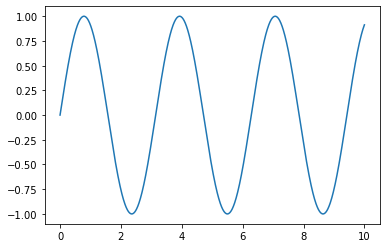

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np);

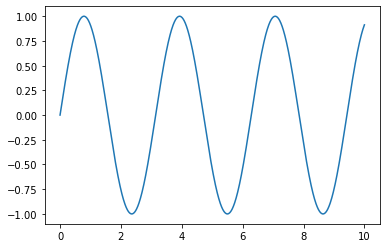

In [ ]:
import jax.numpy as jnp

x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp);

In [ ]:
type(x_np), type(x_jnp)


(numpy.ndarray, jaxlib.xla_extension.DeviceArray)

### Jax arrays

In [ ]:
# NumPy: mutable arrays
x = np.arange(10)
x[0] = 10
print(x)

[10  1  2  3  4  5  6  7  8  9]


In [ ]:
# JAX: immutable arrays
x = jnp.arange(10)
x[0] = 10

TypeError: ignored

In [ ]:
y = x.at[0].set(10)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[10  1  2  3  4  5  6  7  8  9]


In [ ]:
jax_array = jnp.zeros((3,3), dtype=jnp.float32)

updated_array = jax_array.at[1, :].set(1.0)
print("updated array:\n", updated_array)

updated array:
 [[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


In [ ]:
print("original array unchanged:\n", jax_array)


original array unchanged:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [ ]:
print("original array:")
jax_array = jnp.ones((5, 6))
print(jax_array)

new_jax_array = jax_array.at[::2, 3:].add(7.)
print("new array post-addition:")
print(new_jax_array)

original array:
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
new array post-addition:
[[1. 1. 1. 8. 8. 8.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 8. 8. 8.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 8. 8. 8.]]


In [ ]:
np.arange(10)[11]

IndexError: ignored

In [ ]:
jnp.arange(10)[11]


DeviceArray(9, dtype=int32)

In [ ]:
np.sum([1, 2, 3])

6

In [ ]:
jnp.sum([1, 2, 3])

TypeError: ignored

In [ ]:
jnp.sum(jnp.array([1, 2, 3]))

DeviceArray(6, dtype=int32)

## NumPy, lax & XLA: JAX API layering

- jax.numpy is a high-level wrapper that provides a familiar interface.

- jax.lax is a lower-level API that is stricter and often more powerful.

- All JAX operations are implemented in terms of operations in XLA – the Accelerated Linear Algebra compiler.

In [ ]:
import jax.numpy as jnp
jnp.add(1, 1.0)  # jax.numpy API implicitly promotes mixed types

DeviceArray(2., dtype=float32, weak_type=True)

In [ ]:
from jax import lax
lax.add(1, 1.0)  # jax.lax API requires explicit type promotion.

TypeError: ignored

In [ ]:
lax.add(jnp.float32(1), 1.0)


DeviceArray(2., dtype=float32)

## Using `jit()` to speed up functions

In [ ]:
def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = random.normal(key, (1000000,))
%timeit selu(x).block_until_ready()

938 µs ± 110 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
selu_jit = jit(selu)
%timeit selu_jit(x).block_until_ready()

135 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Static variabels

When we jit-compile a function, we usually want to compile a version of the function that works for many different argument values, so that we can cache and reuse the compiled code. That way we don’t have to re-compile on each function evaluation.

Not all JAX code can be JIT compiled, as it requires array shapes to be static & known at compile time.

In [ ]:
def get_negatives(x):
  return x[x < 0]

x = jnp.array(np.random.randn(10))
get_negatives(x)

DeviceArray([-0.7117928 , -1.2171216 , -0.36428484, -0.7236529 ,
             -0.306114  , -1.1640213 ], dtype=float32)

In [ ]:
jit(get_negatives)(x)


NonConcreteBooleanIndexError: ignored

In [ ]:
@jit
def f(x, y):
  print("Running f():")
  print(f"  x = {x}")
  print(f"  y = {y}")
  result = jnp.dot(x + 1, y + 1)
  print(f"  result = {result}")
  return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
f(x, y)

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=0/1)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=0/1)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=0/1)>


DeviceArray([3.1510396, 6.275742 , 8.621445 ], dtype=float32)

In [ ]:
x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
f(x2, y2)

DeviceArray([2.3720539, 1.0529385, 1.6060468], dtype=float32)

In [ ]:
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

f = jit(f)

print(f(2.))

ConcretizationTypeError: ignored

In [ ]:
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

f = jit(f, static_argnums=(0,))

print(f(2.))

12.0


In [ ]:
@jit
def f(x, neg):
  return -x if neg else x

f(1, True)

ConcretizationTypeError: ignored

In [ ]:
from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
  return -x if neg else x

f(1, True)

DeviceArray(-1, dtype=int32, weak_type=True)

### Static operators

In [ ]:
import jax.numpy as jnp
from jax import jit

@jit
def f(x):
  return x.reshape(jnp.array(x.shape).prod())

x = jnp.ones((2, 3))
f(x)

TypeError: ignored

In [ ]:
@jit
def f(x):
  print(f"x = {x}")
  print(f"x.shape = {x.shape}")
  print(f"jnp.array(x.shape).prod() = {jnp.array(x.shape).prod()}")
  # comment this out to avoid the error:
  # return x.reshape(jnp.array(x.shape).prod())

f(x)

x = Traced<ShapedArray(float32[2,3])>with<DynamicJaxprTrace(level=0/1)>
x.shape = (2, 3)
jnp.array(x.shape).prod() = Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>


In [ ]:
from jax import jit
import jax.numpy as jnp
import numpy as np

@jit
def f(x):
  return x.reshape((np.prod(x.shape),))

f(x)

DeviceArray([1., 1., 1., 1., 1., 1.], dtype=float32)

## Taking derivatives with `grad()`

In [ ]:
def sum_logistic(x):
  return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small))

[0.25       0.19661194 0.10499357]


In [ ]:
def first_finite_differences(f, x):
  eps = 1e-3
  return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in jnp.eye(len(x))])


print(first_finite_differences(sum_logistic, x_small))

[0.24998187 0.1965761  0.10502338]


In [ ]:
print(grad(jit(grad(jit(grad(sum_logistic)))))(1.0))

-0.0353256


In [ ]:
grad_ord_3 = grad(grad(grad(sum_logistic)))
%timeit grad_ord_3(1.0)

21.5 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
grad_ord_3_part_jit = grad(grad(jit(grad(sum_logistic))))
%timeit grad_ord_3_part_jit(1.0)

6.81 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
grad_ord_3_jit = grad(jit(grad(jit(grad(sum_logistic)))))
%timeit grad_ord_3_jit(1.0)

3.91 ms ± 90.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
from jax import jacfwd, jacrev

def hessian(fun):
  return jit(jacfwd(jacrev(fun)))

In [ ]:
hessian_jit = hessian(sum_logistic)
%timeit hessian_jit(1.0)

142 µs ± 7.74 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Auto-vectorization with `vmap()`

In [ ]:
mat = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(v):
  return jnp.dot(mat, v)

In [ ]:
def naively_batched_apply_matrix(v_batched):
  return jnp.stack([apply_matrix(v) for v in v_batched])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
3.46 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
@jit
def batched_apply_matrix(v_batched):
  return jnp.dot(v_batched, mat.T)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
103 µs ± 1.55 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
@jit
def vmap_batched_apply_matrix(v_batched):
  return vmap(apply_matrix)(v_batched)

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
53.5 µs ± 2.47 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
